## First step in gap analysis is to determine the AEP based on operational data.

In [1]:
%load_ext autoreload
%autoreload 2

This notebook provides an overview and walk-through of the steps taken to produce a plant-level operational energy asssessment (OA) of a wind plant in the PRUF project. The La Haute-Borne wind farm is used here and throughout the example notebooks. 

Uncertainty in the annual energy production (AEP) estimate is calculated through a Monte Carlo approach. Specifically, inputs into the OA code as well as intermediate calculations are randomly sampled based on their specified or calculated uncertainties. By performing the OA assessment thousands of times under different combinations of the random sampling, a distribution of AEP values results from which uncertainty can be deduced. Details on the Monte Carlo approach will be provided throughout this notebook.

### Step 1: Import plant data into notebook

A zip file included in the OpenOA 'examples/data' folder needs to be unzipped to run this step. Note that this zip file should be unzipped automatically as part of the project.prepare() function call below. Once unzipped, 4 CSV files will appear in the 'examples/data/la_haute_borne' folder.

In [2]:
import os
import copy
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

from openoa.analysis.aep import MonteCarloAEP
from openoa.utils import pandas_plotting

import project_ENGIE

In the call below, make sure the appropriate path to the CSV input files is specfied. In this example, the CSV files are located directly in the 'examples/data/la_haute_borne' folder

In [3]:
# Load plant object
project = project_ENGIE.prepare('./data/la_haute_borne')

INFO:root:Loading SCADA data
INFO:root:SCADA data loaded
INFO:root:Timestamp conversion to datetime and UTC
INFO:root:Removing out of range of temperature readings
INFO:root:Flagging unresponsive sensors
INFO:root:Converting pitch to the range [-180, 180]
INFO:root:Calculating energy production
INFO:root:Reading in the meter data
INFO:root:Reading in the curtailment data
INFO:root:Reading in the reanalysis data and calculating the extra fields
INFO:root:Reading in the asset data


### Step 2: Review the data

Several Pandas data frames have now been loaded. Histograms showing the distribution of the plant-level metered energy, availability, and curtailment are shown below:

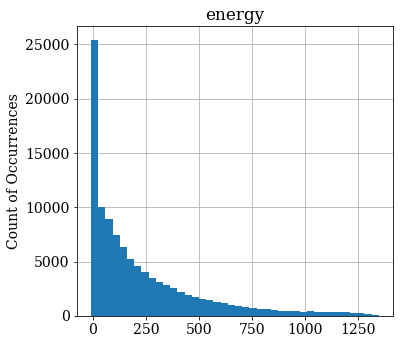

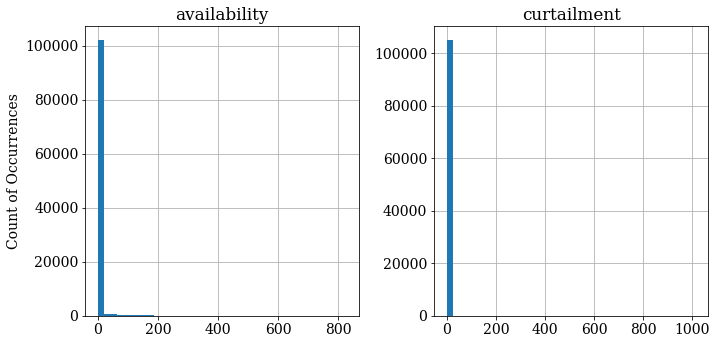

In [4]:
pandas_plotting.column_histograms(project.meter, columns=["energy"])
pandas_plotting.column_histograms(project.curtail, columns=["availability", "curtailment"])

### Step 3: Process the data into monthly averages and sums 

The raw plant data can be in different time resolutions (in this case 10-minute periods). The following steps process the data into monthly averages and combine them into a single 'monthly' data frame to be used in the OA assessment.

In [5]:
project.meter.head()

,energy
time,
2014-01-01 00:00:00,369.726
2014-01-01 00:10:00,376.409
2014-01-01 00:20:00,309.199
2014-01-01 00:30:00,350.176
2014-01-01 00:40:00,286.333


First, we'll create a MonteCarloAEP object which is used to calculate long-term AEP. Two renalaysis products are specified as arguments.

In [6]:
pa = MonteCarloAEP(project, reanal_products = ['era5', 'merra2'])

INFO:openoa.analysis.aep:Initializing MonteCarloAEP Analysis Object


Let's view the result. Note the extra fields we've calculated that we'll use later for filtering:
  - energy_nan_perc : the percentage of NaN values in the raw revenue meter data used in calculating the monthly sum. If this value is too large, we shouldn't include this month
  - nan_flag : if too much energy, availability, or curtailment data was missing for a given month, flag the result
  - num_days_expected : number of days in the month (useful for normalizing monthly gross energy later)
  - num_days_actual : actual number of days per month as found in the data (used when trimming monthly data frame)

In [7]:
# View the monthly data frame
pa._aggregate.head()

,energy_gwh,energy_nan_perc,num_days_expected,num_days_actual,availability_gwh,curtailment_gwh,gross_energy_gwh,availability_pct,curtailment_pct,avail_nan_perc,curt_nan_perc,nan_flag,availability_typical,curtailment_typical,combined_loss_valid,era5,merra2
time,,,,,,,,,,,,,,,,,
2014-01-01,1.279667,0.0,31,31,0.008721,0.000000,1.288387,0.006769,0.000000,0.0,0.0,False,True,True,True,7.314878,7.227947
2014-02-01,1.793873,0.0,28,28,0.005280,0.000000,1.799153,0.002934,0.000000,0.0,0.0,False,True,True,True,8.347006,8.598686
2014-03-01,0.805549,0.0,31,31,0.000151,0.000000,0.805700,0.000188,0.000000,0.0,0.0,False,True,True,True,5.169673,5.207071
2014-04-01,0.636472,0.0,30,30,0.002773,0.000000,0.639245,0.004338,0.000000,0.0,0.0,False,True,True,True,4.756275,4.872304
2014-05-01,1.154255,0.0,31,31,0.015176,0.000225,1.169656,0.012974,0.000192,0.0,0.0,False,True,True,True,6.162751,6.351635


### Step 4: Review reanalysis data

Reanalysis data will be used to long-term correct the operational energy over the plant period of operation to the long-term. It is important that we only use reanalysis data that show reasonable trends over time with no noticeable discontinuities. A plot like below, in which normalized annual wind speeds are shown from 1997 to present, provides a good first look at data quality.

The plot shows that both of the reanalysis products track each other reasonably well and seem well-suited for the analysis.

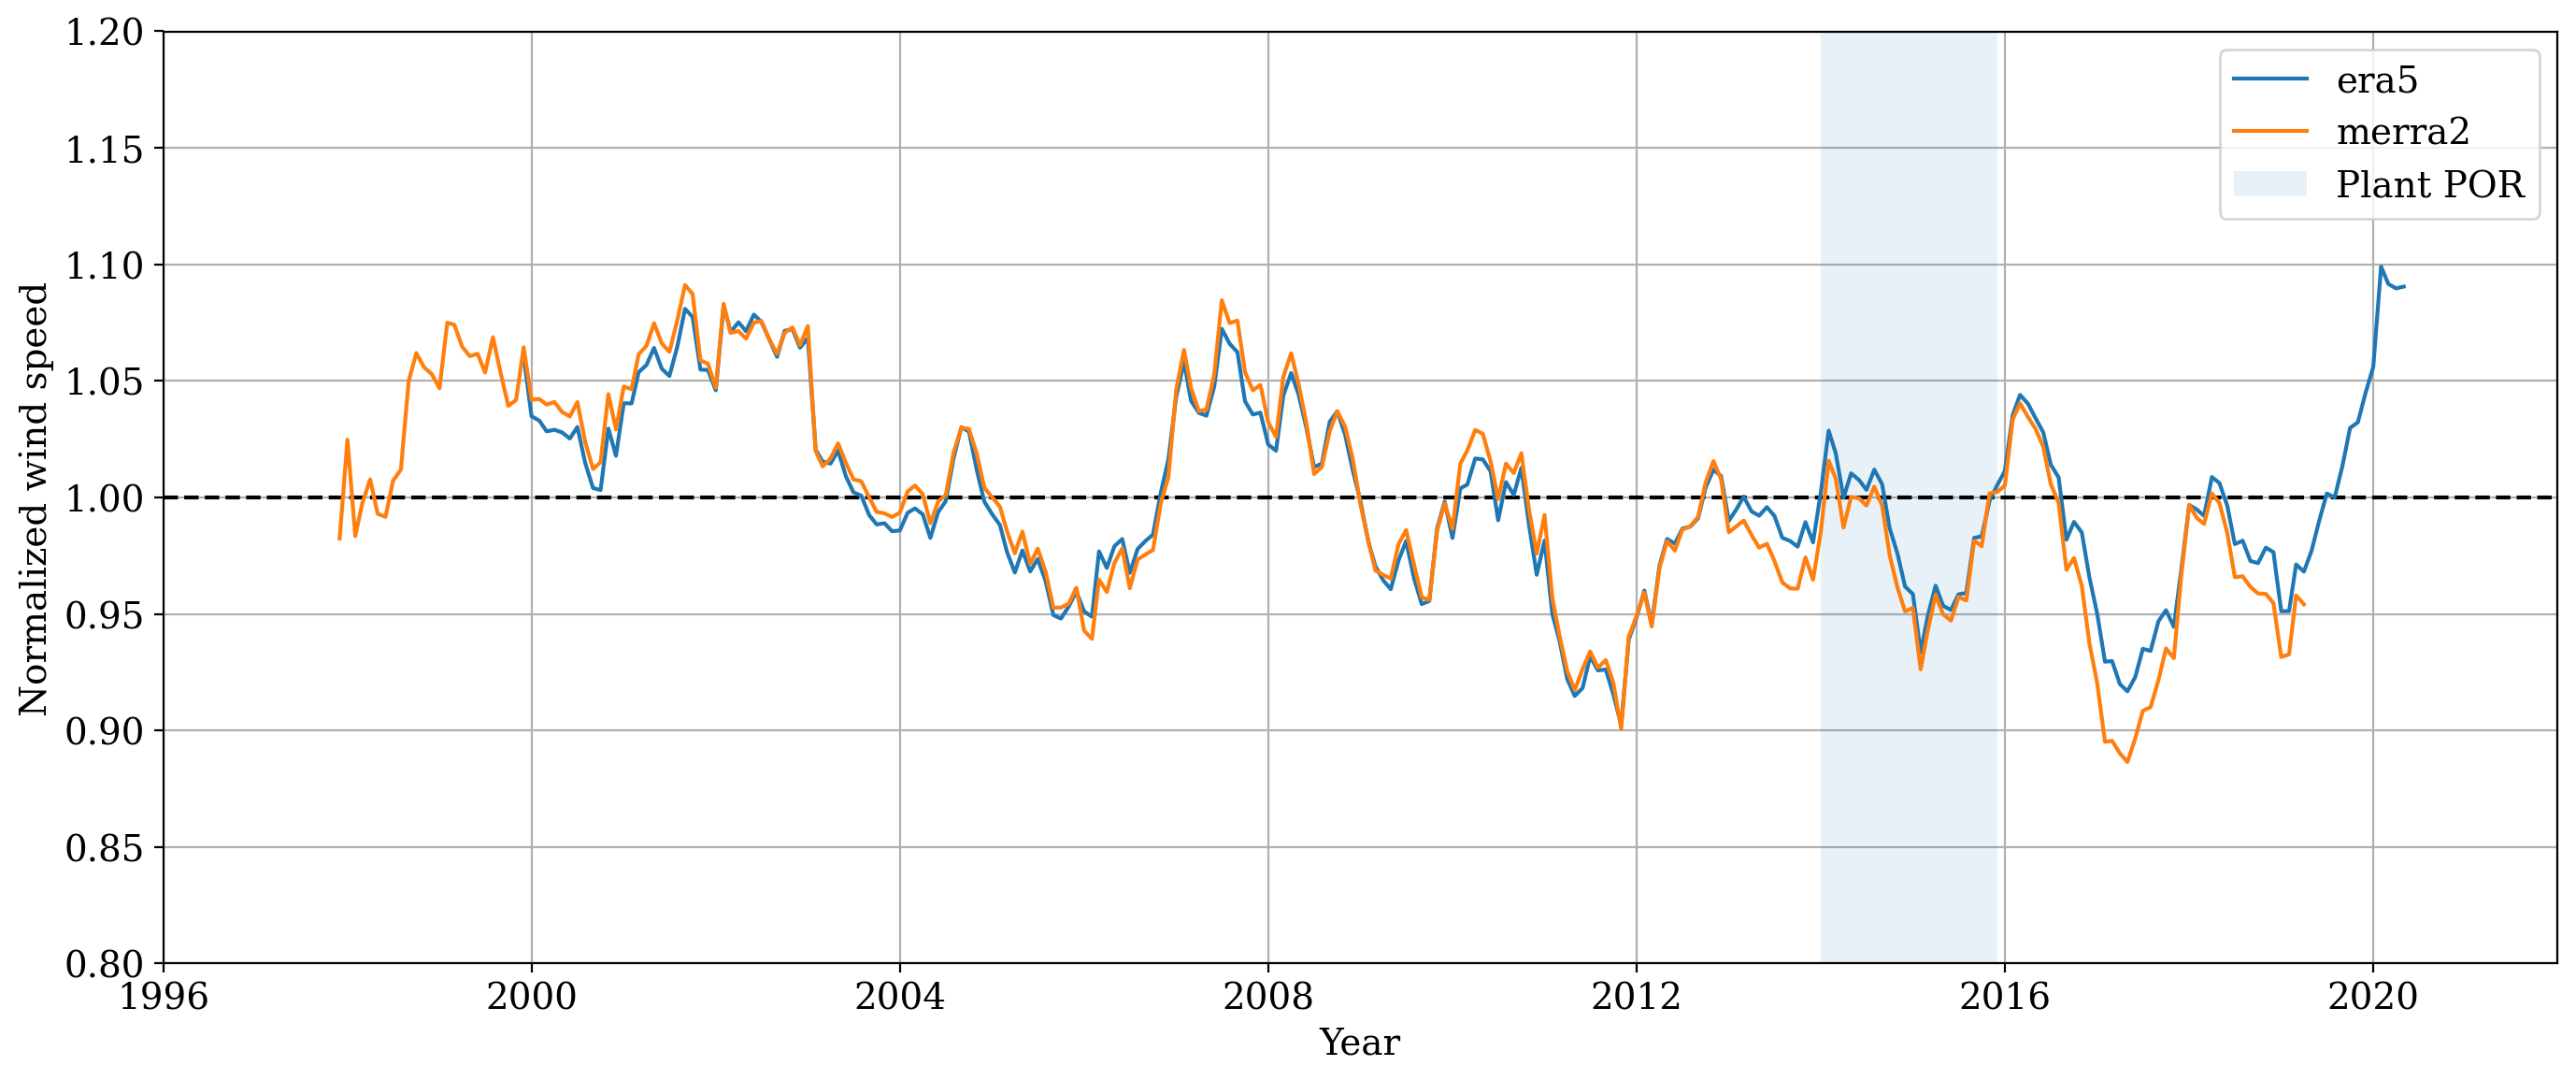

In [8]:
pandas_plotting.plot_normalized_monthly_reanalysis_windspeed(
    pa,
    return_fig=False,
    xlim=(datetime(1996, 1, 1), datetime(2021, 12, 31)),
    ylim=(0.8, 1.2),
)

# NOTE: This plotting method is also attached to the MonteCarloAEP class
# pa.plot_normalized_monthly_reanalysis_windspeed(
#     return_fig=False,
#     xlim=(datetime(1996, 1, 1), datetime(2021, 12, 31)),
#     ylim=(0.8, 1.2),
# )

### Step 5: Review energy and loss data

It is useful to take a look at the energy data and make sure the values make sense. We begin with scatter plots of gross energy and wind speed for each reanalysis product. We also show a time series of gross energy, as well as availability and curtailment loss. 

Let's start with the scatter plots of gross energy vs wind speed for each reanalysis product. Here we use the 'Robust Linear Model' (RLM) module of the Statsmodels package with the default Huber algorithm to produce a regression fit that excludes outliers. Data points in red show the outliers, and were excluded based on a Huber sensitivity factor of 3.0.

The plots below reveal that:
  - there are some outliers
  - Both renalysis products are strongly correlated with plant energy
  
If the user would like the RLM outlier detection algorithm to be used in the Monte Carlo analysis, the "outlier_detection" parameter should be set to "True" when calling the plant_analysis class. 

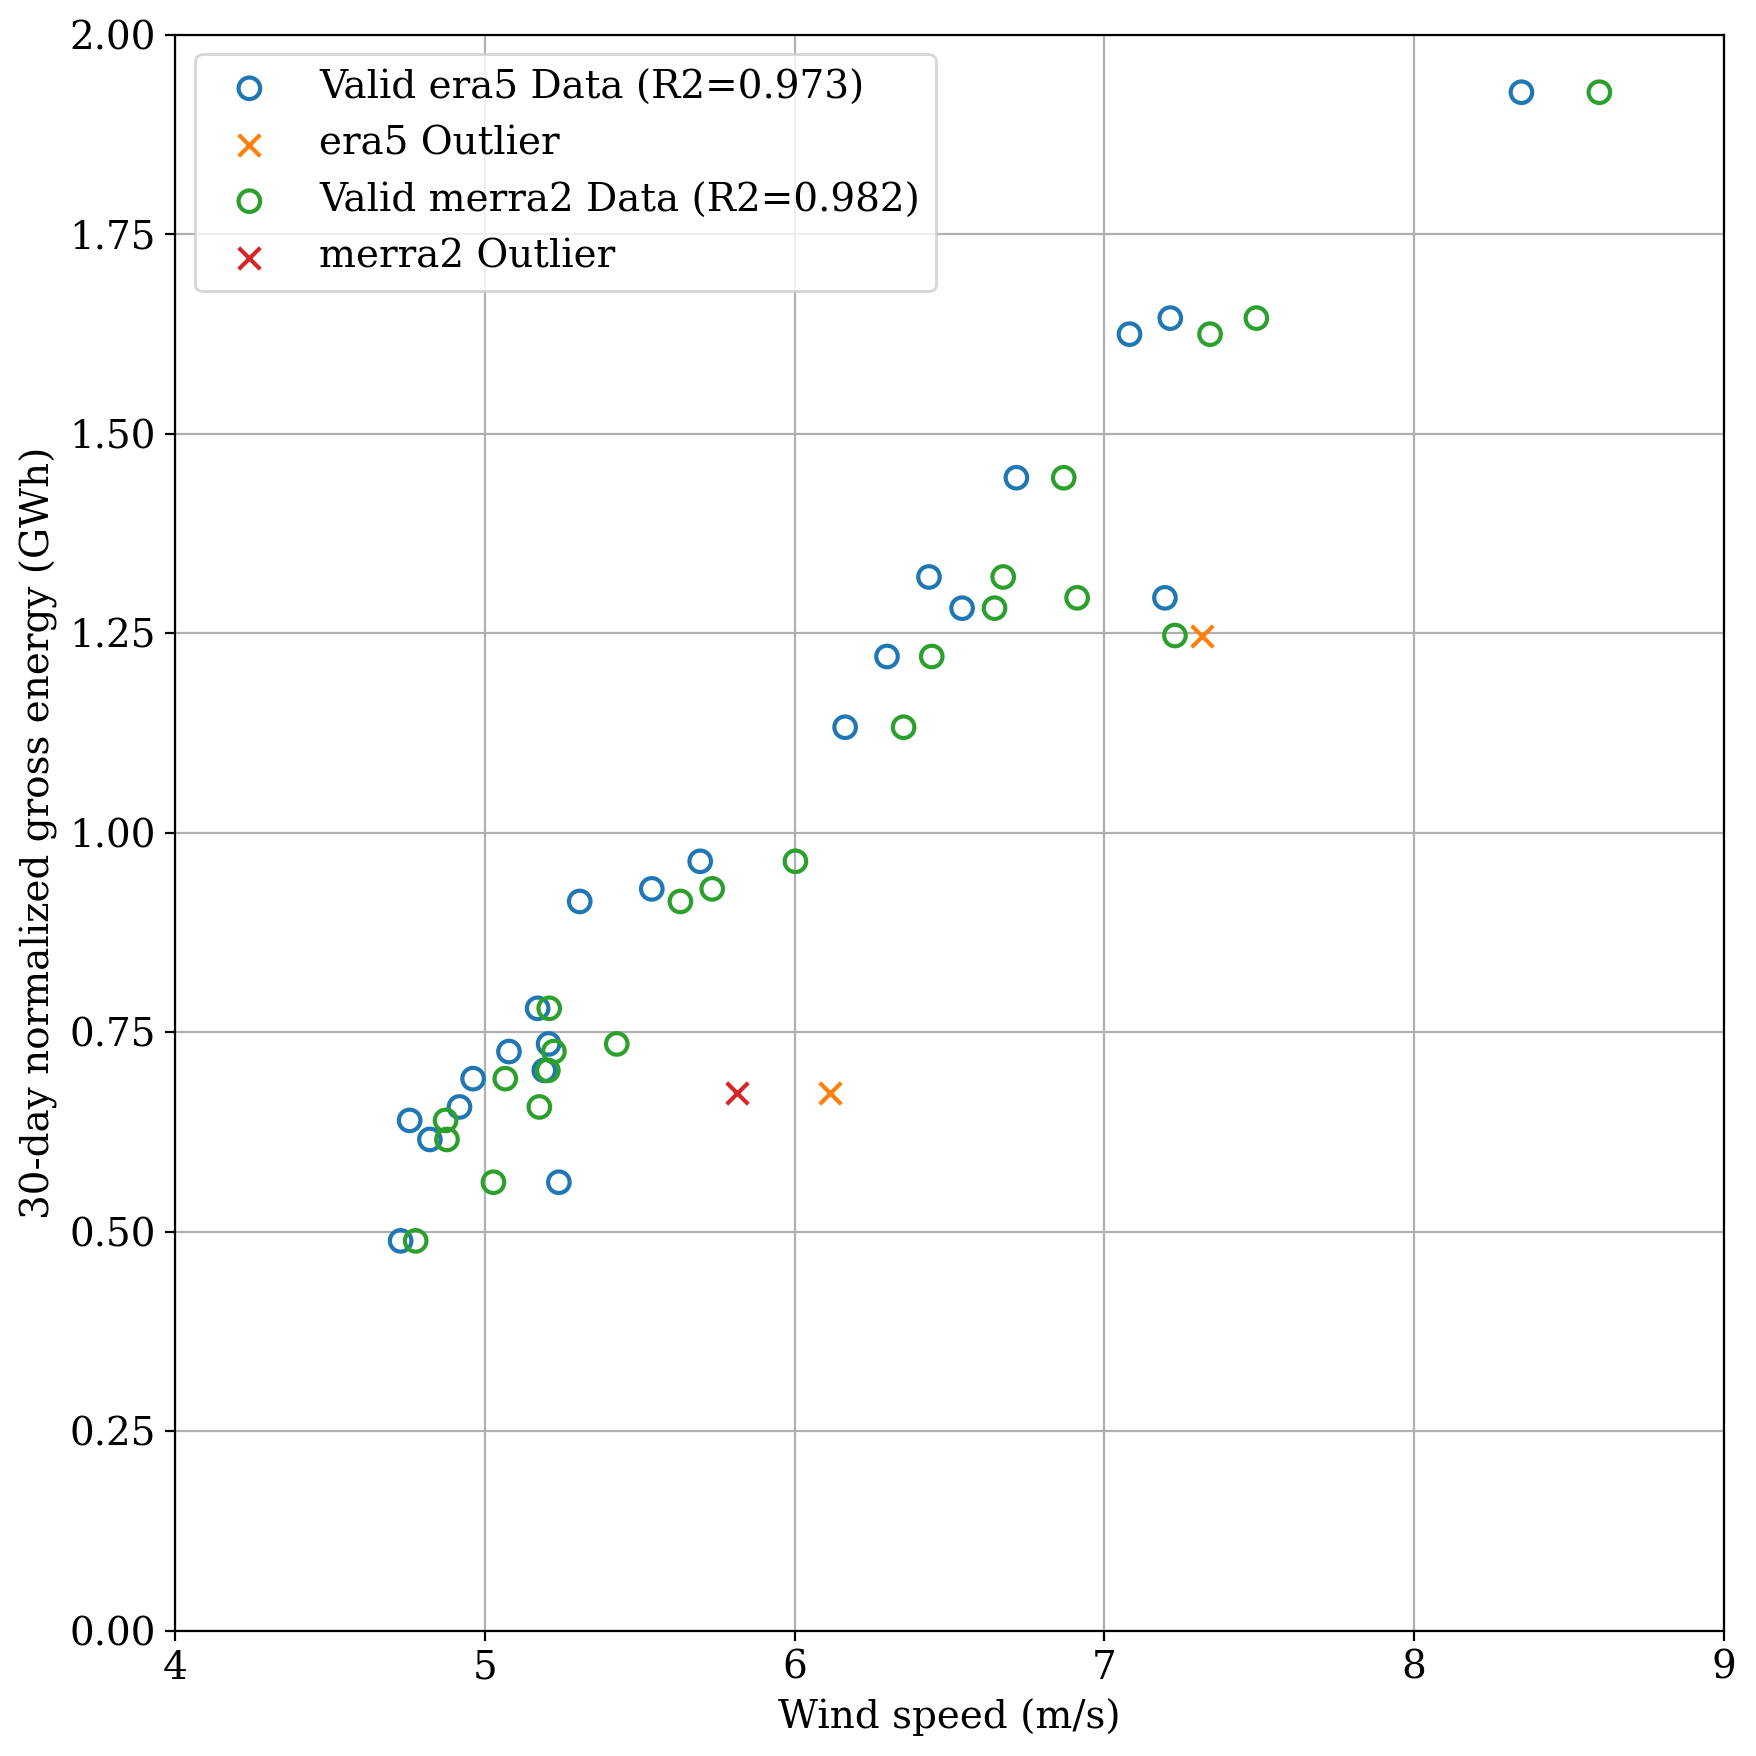

In [9]:
pandas_plotting.plot_reanalysis_gross_energy_data(
    pa,
    outlier_threshold=3,
    xlim=(4, 9),
    ylim=(0, 2),
    plot_kwargs=dict(s=60),
)

# NOTE: Can also be run as the following
# pa.plot_reanalysis_gross_energy_data(outlier_threshold=3, xlim=(4, 9), ylim=(0, 2), plot_kwargs=dict(s=60))

Next we show time series plots of the monthly gross energy, availabilty, and curtialment. Note that the availability and curtailment data were estimated based on SCADA data from the plant.

Long-term availability and curtailment losses for the plant are calculated based on average percentage losses for each calendar month. Summing those average values weighted by the fraction of long-term gross energy generated in each month yields the long-term annual estimates. Weighting by monthly long-term gross energy helps account for potential correlation between losses and energy production (e.g., high availability losses in summer months with lower energy production). The long-term losses are calculated in Step 9.

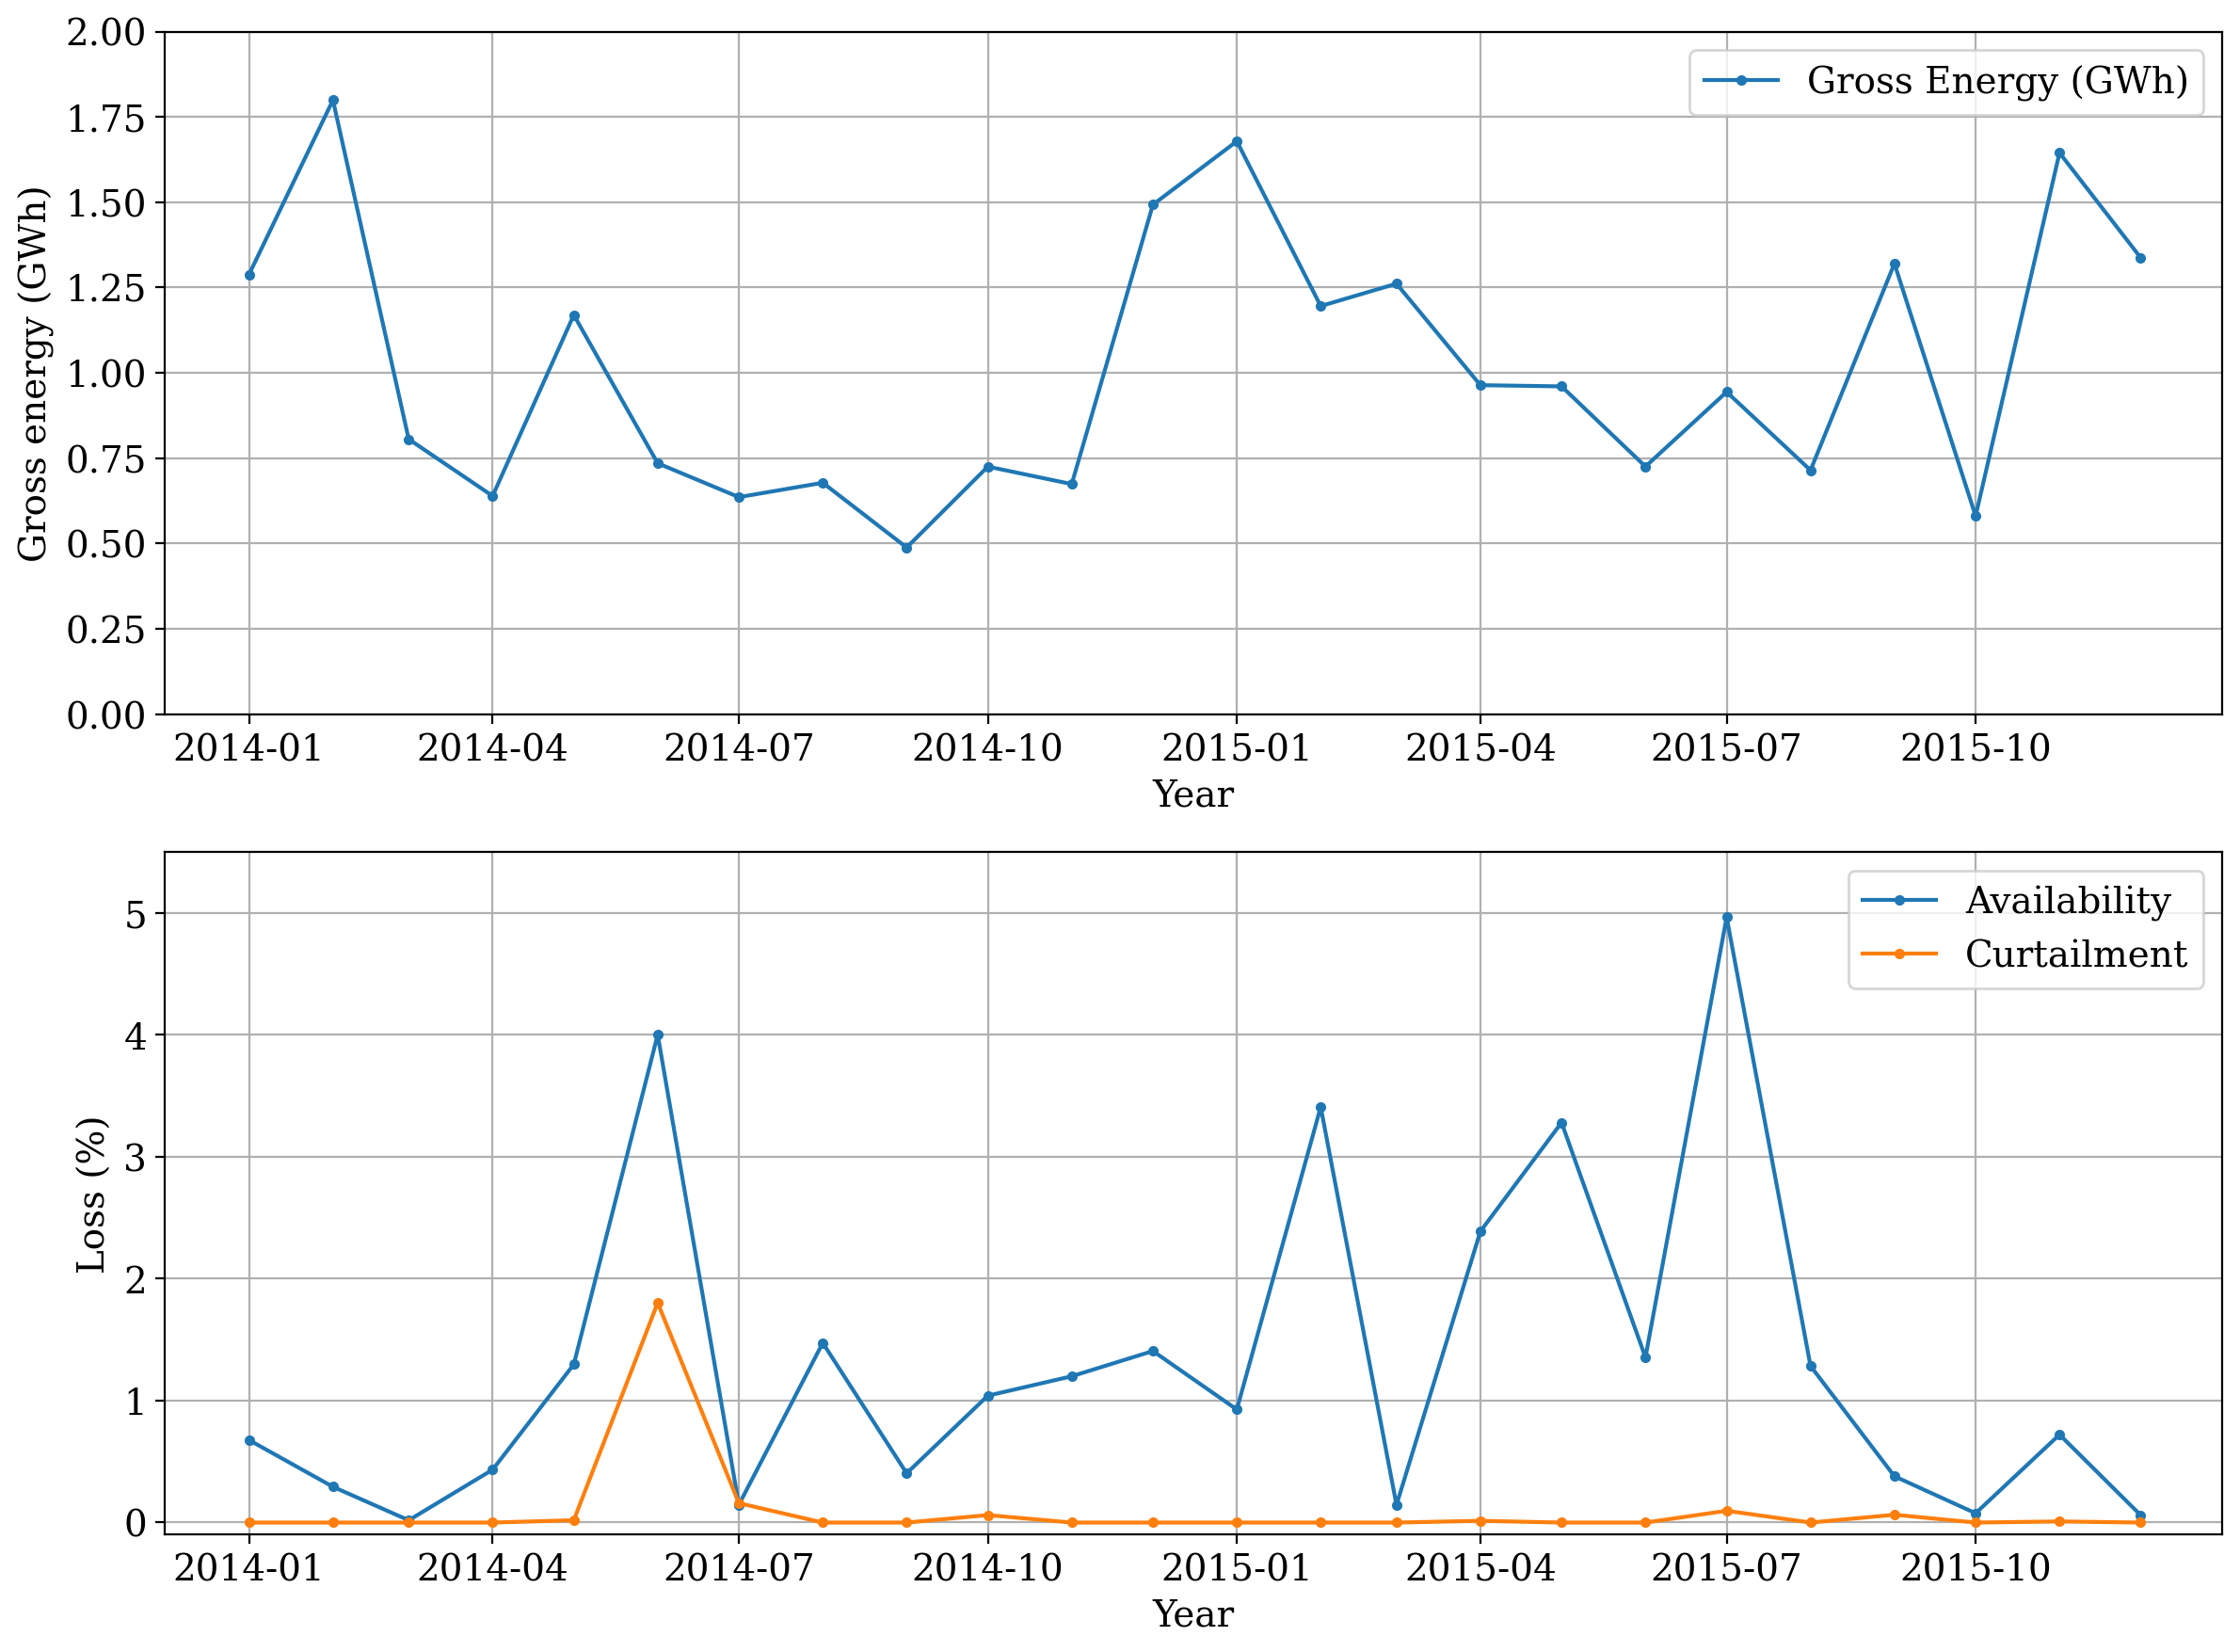

In [10]:
pandas_plotting.plot_aggregate_plant_data_timeseries(
    pa,
    xlim=(datetime(2013, 12, 1), datetime(2015, 12, 31)),
    ylim_energy=(0, 2),
    ylim_loss=(-0.1, 5.5)
)

# NOTE: Can also be run as the following
# pa.plot_aggregate_plant_data_timeseries(
#     xlim=(datetime(2013, 12, 1), datetime(2015, 12, 31)),
#     ylim_energy=(0, 2),
#     ylim_loss=(-0.1, 5.5)
# )

### Step 6: Specify availabilty and curtailment data not represenative of actual plant performance

There may be anomalies in the reported availabilty that shouldn't be considered representative of actual plant performance. Force majeure events (e.g. lightning) are a good example. Such losses aren't typically considered in pre-construction AEP estimates; therefore, plant availablity loss reported in an operational AEP analysis should also not include such losses. 

The 'availability_typical' and 'curtailment_typical' fields in the monthly data frame are initially set to True. Below, individual months can be set to 'False' if it is deemed those months are unrepresentative of long-term plant losses. By flagging these months as false, they will be omitted when assessing average availabilty and curtailment loss for the plant.

Justification for removing months from assessing average availabilty or curtailment should come from conversations with the owner/operator. For example, if a high-loss month is found, reasons for the high loss should be discussed with the owner/operator to determine if those losses can be considered representative of average plant operation.

In [11]:
# For illustrative purposes, let's suppose a few months aren't representative of long-term losses
pa._aggregate.loc['2014-11-01',['availability_typical','curtailment_typical']] = False
pa._aggregate.loc['2015-07-01',['availability_typical','curtailment_typical']] = False

### Step 7: Select reanalysis products to use

Based on the assessment of reanalysis products above (both long-term trend and relationship with plant energy), we now set which reanalysis products we will include in the OA. For this particular case study, we use both products given the high regression relationships.

### Step 8: Set up Monte Carlo inputs

The next step is to set up the Monte Carlo framework for the analysis. Specifically, we identify each source of uncertainty in the OA estimate and use that uncertainty to create distributions of the input and intermediate variables from which we can sample for each iteration of the OA code. For input variables, we can create such distributions beforehand. For intermediate variables, we must sample separately for each iteration.

Detailed descriptions of the sampled Monte Carlo inputs, which can be specified when initializing the MonteCarloAEP object if values other than the defaults are desired, are provided below:

 - uncertainty_meter : Revenue meter energy measurements are associated with a measurement uncertainty of around 0.5%. This uncertainty is used to create a distribution centered at 1 (and with standard deviation therefore of 0.005). This column represents random samples from that distribution. For each iteration of the OA code, a value from this column is multiplied by the monthly revenue meter energy data before the data enter the OA code, thereby capturing the 0.5% uncertainty.
 
 - uncertainty_losses : Reported availability and curtailment losses are estimates and are associated with uncertainty. For now, we assume the reported values are associated with an uncertainty of 5%. Similar to above, we therefore create a distribution centered at 1 (with std of 0.05) from which we sample for each iteration of the OA code. These sampled values are then multiplied by the availability and curtaiment data independently before entering the OA code to capture the 5% uncertainty in the reported values.
 
 - uncertainty_windiness : This intends to capture the uncertainty associated with the number of historical years an analyst chooses to use in the windiness correction. The industry standard is typically 20 years and is based on the assumption that year-to-year wind speeds are uncorrelated. However, a growing body of research suggests that there is some correlation in year-to-year wind speeds and that there are trends in the resource on the decadal timescale. To capture this uncertainty both in the long-term trend of the resource and the analyst choice, we randomly sample integer values betweeen 10 and 20 as the number of years to use in the windiness correction.
 
 - uncertainty_loss_max : Due to uncertainty in reported availability and curtailment estimates, months with high combined losses are associated with high uncertainty in the calculated gross energy. It is common to remove such data from analysis. For this analysis, we randomly sample float values between 0.1 and 0.2 (i.e. 10% and 20%) to serve as criteria for the combined availability and curtailment losses. Specifically, months are excluded from analysis if their combined losses exceeds that criteria for the given OA iteration.

 - uncertainty_nan_energy: Threshold for removing days/months based on the fraction of NaNs in the data.

 - outlier_detection: Whether to perform (True) or not (False) outlier detection filtering. The default value is set to False.

 - uncertainty_outlier : Sample values between 1 and 3 which set the Huber algorithm outlier detection parameter (for linear regression; for machine learning regression algorithms, please see example 2b). Varying this threshold accounts for analyst subjectivity on what data points constitute outliers and which do not.
  
 - reanalyis_product : This captures the uncertainty of using different reanalysis products and, lacking a better method, is a proxy way of capturing uncertainty in the modelled monthly wind speeds. For each iteration of the OA code, one of the reanalysis products that we've already determined as valid (see the cells above) is selected.
 
Finally, we note that the operational data are also randomly resampled at each iteration using bootstrapping to help quantify uncertainty in the results. Consequently, different slope and intercept values for the linear regression model mapping monthly wind speed to energy production are determined each Monte Carlo iteration.

### Step 9: Run the OA code 

We're now ready to run the Monte Carlo based OA code. We repeat the OA process "num_sim" times using different sampling combinations of the input and intermediate variables to produce a distribution of AEP values.

A single line of code here in the notebook performs this step, but below is more detail on what is being done. 

Steps in OA process:

  - Set the wind speed and gross energy data to be used in the regression based on i) the reanalysis product to be used (Monte Carlo sampled); ii) randomly resampling which data points are included each Monte Carlo iteration, with replacement (e.g., bootstrapping); iii) the NaN energy data criteria (1%); iv) combined availability and curtailment loss criteria (Monte Carlo sampled); and v) the outlier criteria (Monte Carlo sampled)
  - Normalize gross energy to 30-day months
  - Perform linear regression and determine slope and intercept values, their standard errors, and the covariance between the two 
  - Apply the slope and intercept values to the long-term monthly average wind speeds (based on a 10-20 year historical period as determined by the Monte Carlo process) to calculate long-term monthly gross energy 
  - 'Denormalize' monthly long-term gross energy back to the normal number of days
  - Calculate AEP by subtracting out the long-term avaiability loss (curtailment loss is left in as part of AEP)
  - To account for uncertainty in the AEP for any single year, interannual variability is applied to the AEP estimates from each Monte Carlo iteration based on the standard deviation of the annual AEP values during the historical period 

In [12]:
# Run Monte Carlo based OA
pa.run(num_sim=2000, reanal_subset=['era5', 'merra2'])

INFO:openoa.analysis.aep:Running with parameters: {'uncertainty_meter': 0.005, 'uncertainty_losses': 0.05, 'uncertainty_loss_max': array([10., 20.]), 'uncertainty_windiness': array([10., 20.]), 'uncertainty_nan_energy': 0.01, 'num_sim': 2000, 'reanal_subset': ['era5', 'merra2']}
100%|██████████| 2000/2000 [00:15<00:00, 125.78it/s]
INFO:openoa.analysis.aep:Run completed


The key result is shown below: a distribution of AEP values from which uncertainty can be deduced. In this case, uncertainty is around 10%.

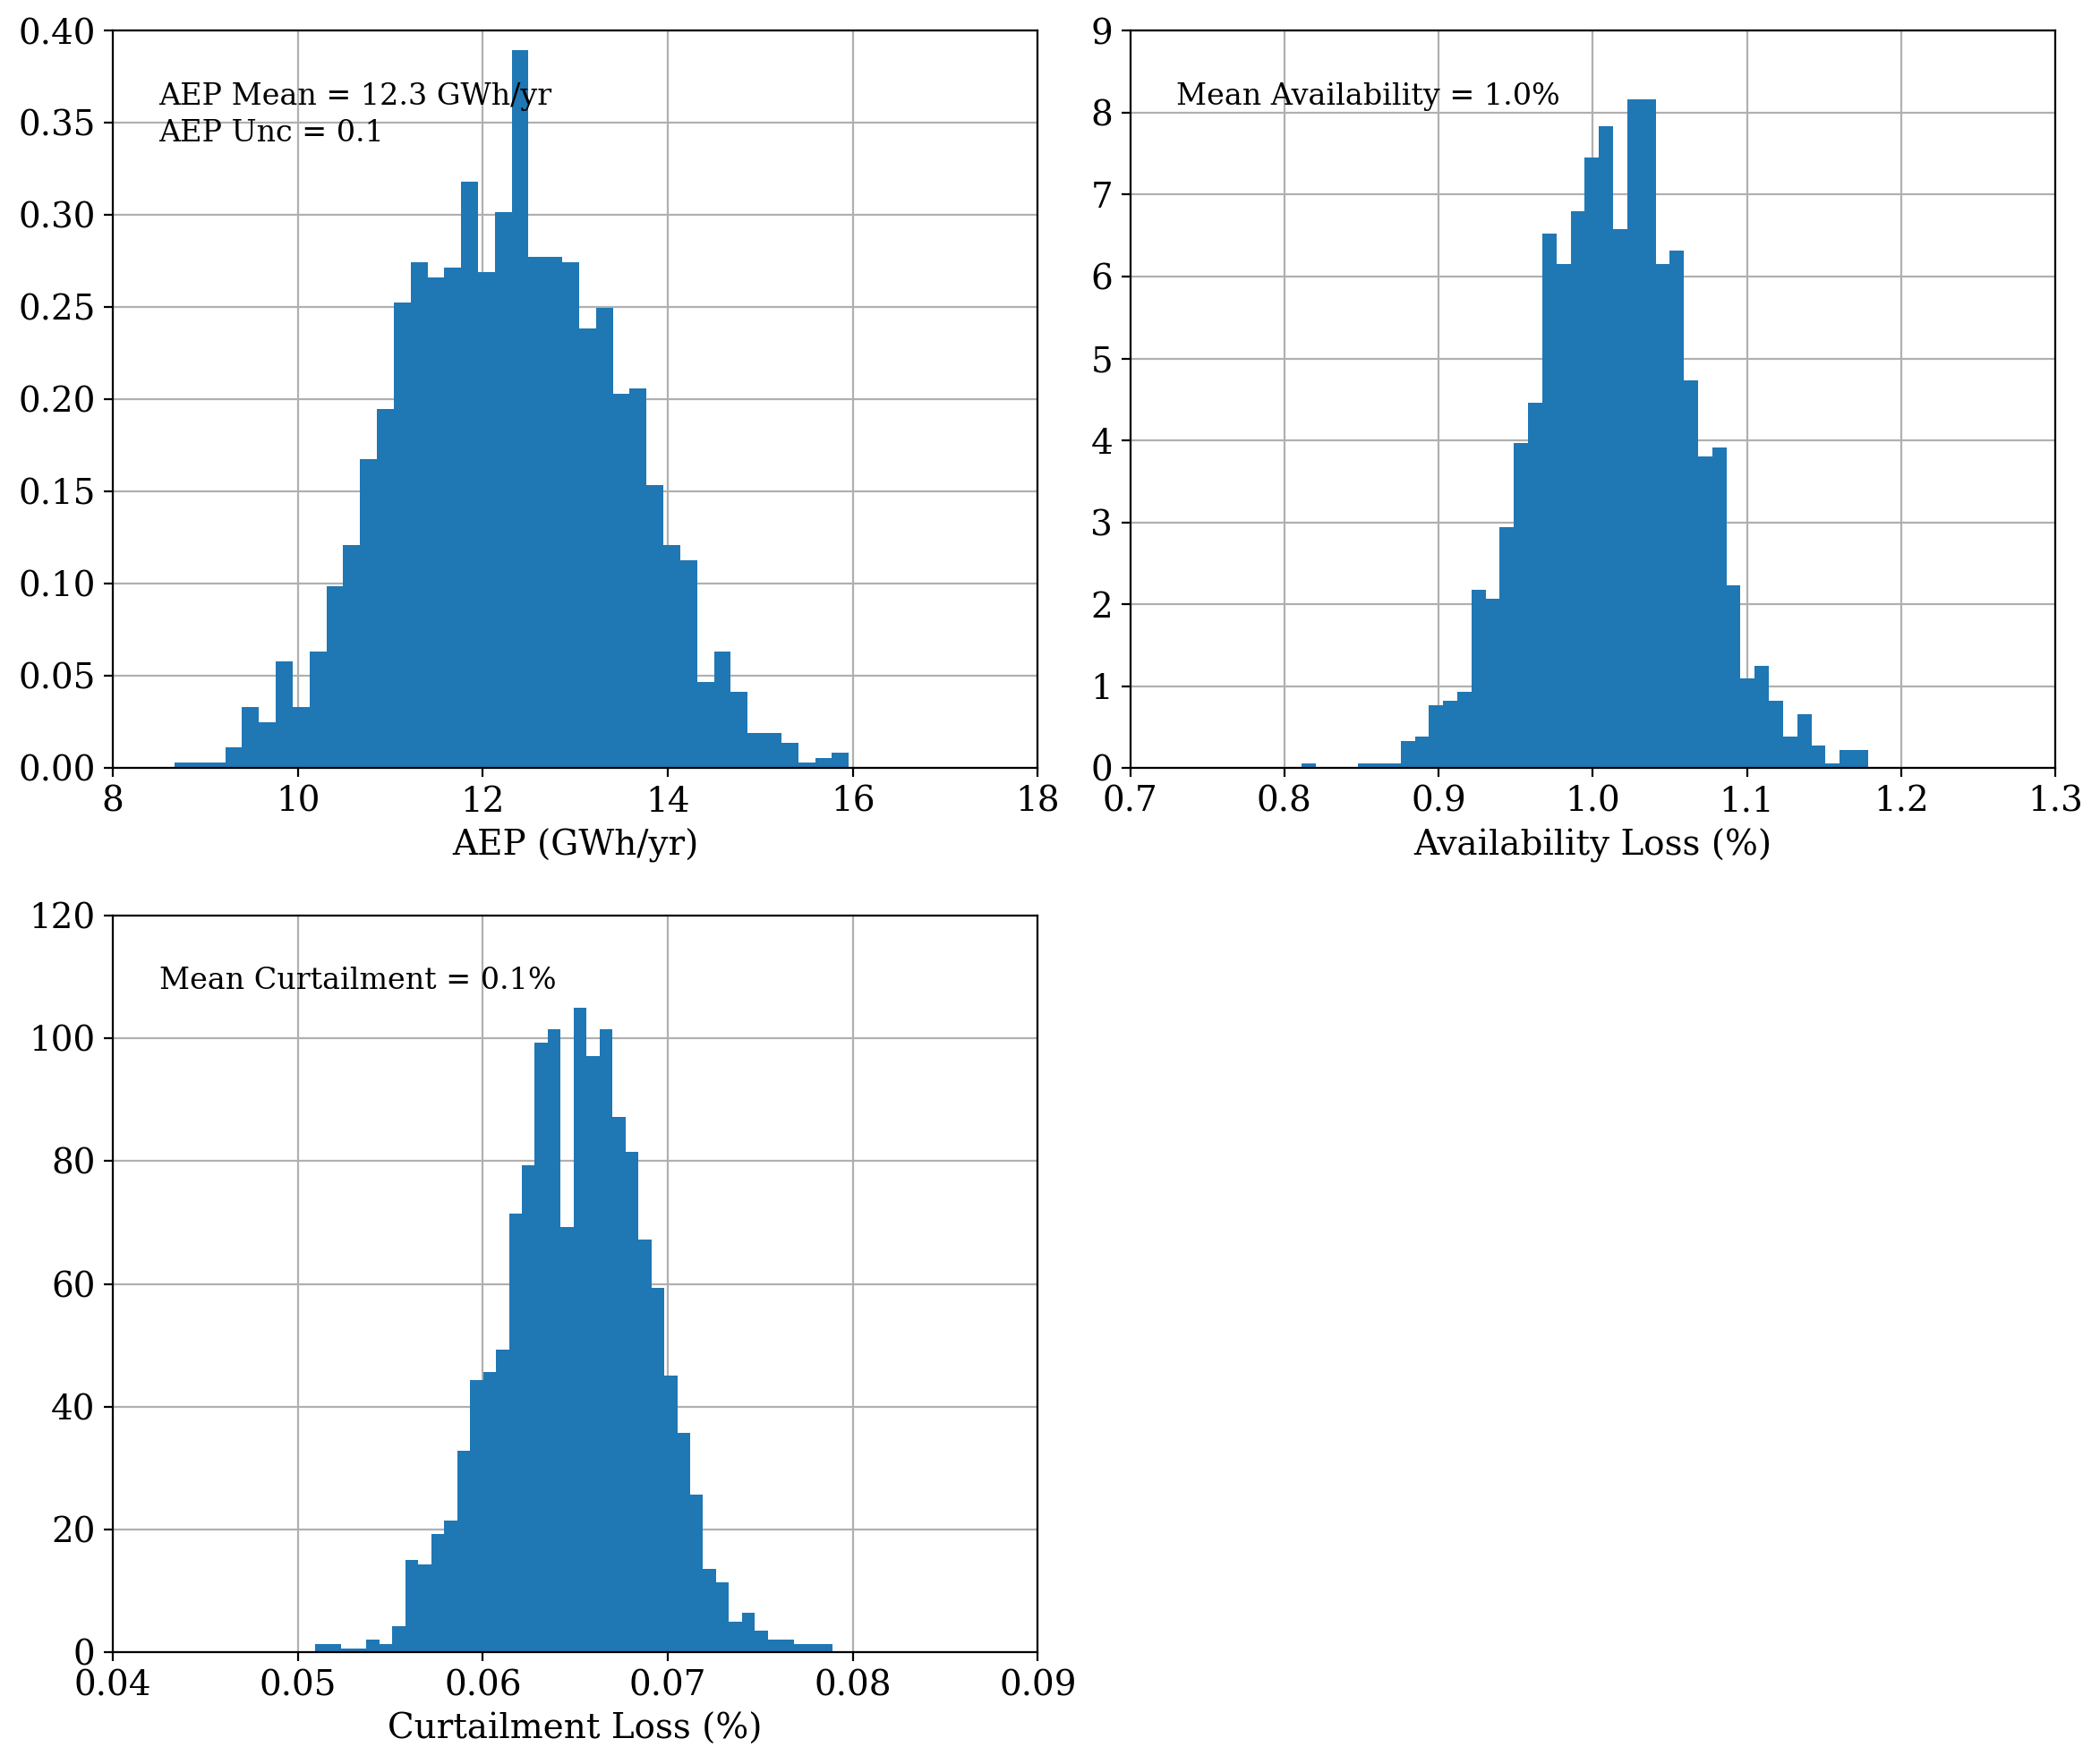

In [13]:
# Plot a distribution of AEP values from the Monte Carlo OA method
pandas_plotting.plot_result_aep_distributions(
    pa,
    xlim_aep=(8, 18),
    xlim_availability=(0.7, 1.3),
    xlim_curtail=(0.04, 0.09),
    ylim_aep=(0, 0.4),
    ylim_availability=(0, 9),
    ylim_curtail=(0, 120),
    annotate_kwargs={"fontsize": 12},
)

# Alternative usage
# pa.plot_result_aep_distributions(
#     xlim_aep=(8, 18),
#     xlim_availability=(0.7, 1.3),
#     xlim_curtail=(0.04, 0.09),
#     ylim_aep=(0, 0.4),
#     ylim_availability=(0, 9),
#     ylim_curtail=(0, 120),
#     annotate_kwargs={"fontsize": 12},
# )

### Step 10: Post-analysis visualization

Here we show some supplementary results of the Monte Carlo OA approach to help illustrate how it works. 

First, it's worth looking at the Monte Carlo tracker data frame again, now that the slope, intercept, and number of outlier fields have been completed. Note that for transparency, debugging, and analysis purposes, we've also included in the tracker data frame the number of data points used in the regression.

In [14]:
# Produce histograms of the various MC-parameters
mc_reg = pd.DataFrame(data = {'slope': pa._mc_slope.ravel(),
                             'intercept': pa._mc_intercept, 
                              'num_points': pa._mc_num_points, 
                              'metered_energy_fraction': pa._inputs.metered_energy_fraction, 
                              'loss_fraction': pa._inputs.loss_fraction,
                              'num_years_windiness': pa._inputs.num_years_windiness, 
                              'loss_threshold': pa._inputs.loss_threshold,
                              'reanalysis_product': pa._inputs.reanalysis_product})

It's useful to plot distributions of each variable to show what is happening in the Monte Carlo OA method. Based on the plot below, we observe the following:

  - metered_energy_fraction, and loss_fraction sampling follow a normal distribution as expected
  - The slope and intercept distributions appear normally distributed, even though different reanalysis products are considered, resulting in different regression relationships. This is likely because the reanalysis products agree with each other closely.
  - 24 data points were used for all iterations, indicating that there was no variation in the number of outlier months removed
  - We see approximately equal sampling of the num_years_windiness, loss_threshold, and reanalysis_product, as expected

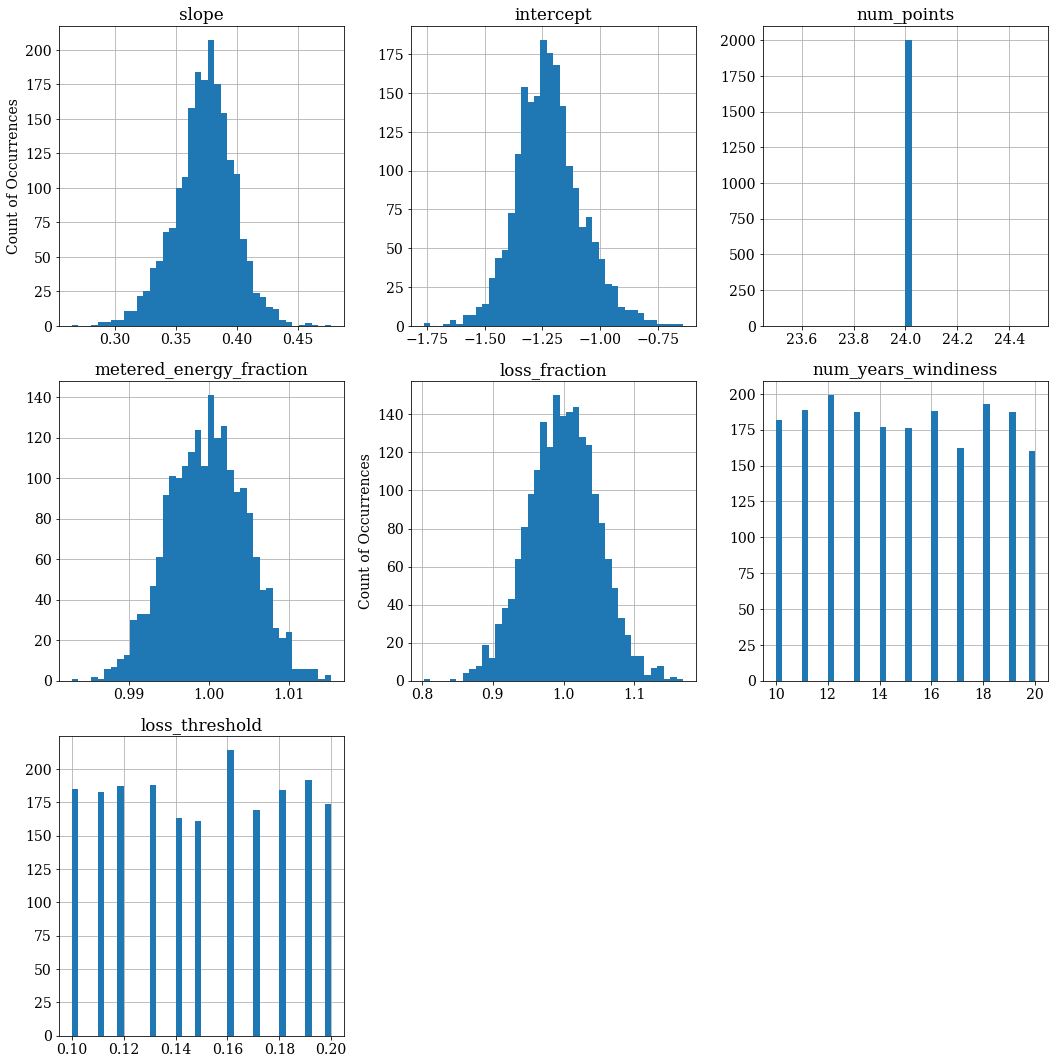

In [15]:
pandas_plotting.column_histograms(mc_reg)

It's worth highlighting the inverse relationship between slope and intercept values under the Monte Carlo approach. Slope and intercept values are strongly negatively correlated (e.g. slope goes up, intercept goes down), as shown below.

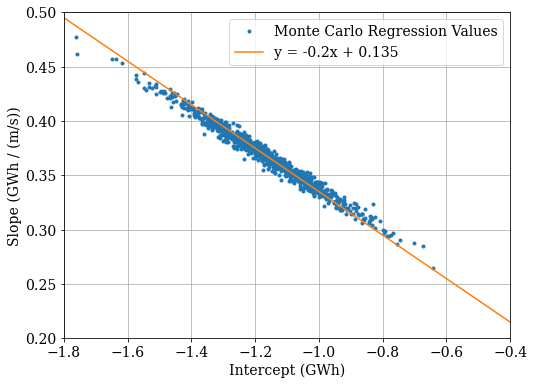

In [16]:
# Produce scatter plots of slope and intercept values. Here we focus on the ERA-5 data
plt.figure(figsize=(8,6))
plt.plot(
    mc_reg.intercept[mc_reg.reanalysis_product =='era5'],
    mc_reg.slope[mc_reg.reanalysis_product =='era5'],
    '.', label="Monte Carlo Regression Values"
)
x = np.linspace(-2, 0, 3)
y = -0.2 * x + 0.135
plt.plot(x, y, label="y = -0.2x + 0.135")
plt.xlabel('Intercept (GWh)')
plt.ylabel('Slope (GWh / (m/s))')
plt.legend()
plt.xlim((-1.8, -0.4))
plt.ylim(0.2, 0.5)
plt.grid()
plt.show()

We can look further at the influence of certain Monte Carlo parameters on the AEP result. For example, let's see what effect the choice of reanalysis product has on the result:

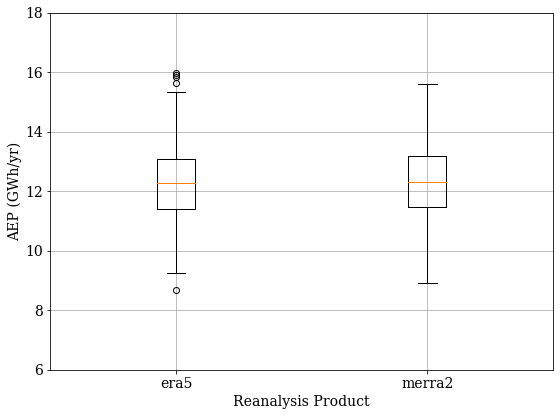

In [17]:
# Boxplot of AEP based on choice of reanalysis product
pandas_plotting.plot_aep_boxplot(pa, parameter=mc_reg['reanalysis_product'], label="Reanalysis Product", ylim=(6, 18))

# Alternatively:
# pa.plot_aep_boxplot(mc_reg['reanalysis_product'], "Reanalysis Product", ylim=(6, 18))

In this case, the two reanalysis products lead to similar AEP estimates, although MERRA2 yields slightly higher uncertainty.

We can also look at the effect on the number of years used in the windiness correction, in the below code block and figure, where we can se that the number of years used in the windiness correction does not significantly impact the AEP estimate.

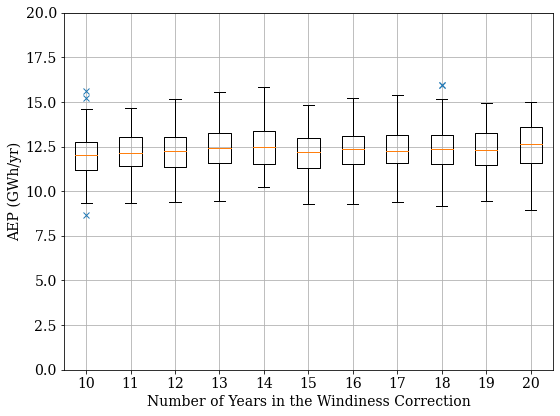

In [18]:
# Boxplot of AEP based on number of years in windiness correction
pandas_plotting.plot_aep_boxplot(
    pa,
    parameter=mc_reg['num_years_windiness'],
    label="Number of Years in the Windiness Correction",
    ylim=(0, 20),
    plot_kwargs={"flierprops":dict(marker="x", markeredgecolor="tab:blue")}
)